In [1]:
# Import Moudles and Packages
import os
import time

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

In [2]:
# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from pytorch_toolbelt import losses
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

import albumentations as A

In [3]:
print("Pytorch version: {}".format(torch.__version__))
print("GPU: {}".format(torch.cuda.is_available()))

print("Device name: ", torch.cuda.get_device_name(0))
print("Device count: ", torch.cuda.device_count())

Pytorch version: 1.10.0+cu102
GPU: True
Device name:  Tesla T4
Device count:  4


In [4]:
# Import local modules
from src import config as C
from src.models import hrnet, resnet, basenet
from src.dataset import kface_dataset as K
from src.dataset import w300_dataset as W
from src.dataset import kface_transform as T
from src.utils.collate_fn import *
from src.utils.print_overwrite import *

In [5]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print(f"| Device : {device}")

| Device : cuda:2


In [6]:
print(f"| Number of image : {len(C.IMAGE_LIST)}")
print(f"| Number of label : {len(C.LABEL_LIST)}")

| Number of image : 100
| Number of label : 100


In [7]:
print(f"| Number of train : {C.LEN_TRAIN_SET}")
print(f"| Number of valid : {C.LEN_VALID_SET}")

| Number of train : 90
| Number of valid : 10


In [8]:
k_dataset = K.kfacedataset(image_list=C.IMAGE_LIST, label_list=C.LABEL_LIST, transform=T.Transforms())
w_dataset = W.FaceLandmarksDataset(W.Transforms())

In [9]:
image, label = w_dataset[0]
print(image.size())
print(label.size())

torch.Size([1, 224, 224])
torch.Size([27, 2])


In [10]:
landmarks = label.view([label.size(0),-1])
print(landmarks.size())

torch.Size([27, 2])


In [11]:
## 300w

# split the dataset into validation and test sets
len_valid_set = int(0.1*len(w_dataset))
len_train_set = len(w_dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(w_dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)

torch.autograd.set_detect_anomaly(True)
# network = basenet.BaseNet()
network = resnet.Network()
network.train()
network.to(device)

criterion = nn.MSELoss()
optimizer = MADGRAD(params=network.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY)

loss_min = np.inf
num_epochs = 40

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0),-1).to(device)
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

The length of Train set is 6000
The length of Valid set is 666
Valid Steps: 333/333  Loss: 0.0031 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0158  Valid Loss: 0.0031
--------------------------------------------------

Minimum Validation Loss of 0.0031 at epoch 1/40
Model Saved

Valid Steps: 333/333  Loss: 0.0017 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0038  Valid Loss: 0.0017
--------------------------------------------------

Minimum Validation Loss of 0.0017 at epoch 2/40
Model Saved

Valid Steps: 333/333  Loss: 0.0012 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0027  Valid Loss: 0.0012
--------------------------------------------------

Minimum Validation Loss of 0.0012 at epoch 3/40
Model Saved

Valid Steps: 333/333  Loss: 0.0015 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0021  Valid Loss: 0.0015
--------------------------------------------------
Val

IndexError: index 2 is out of bounds for dimension 0 with size 2

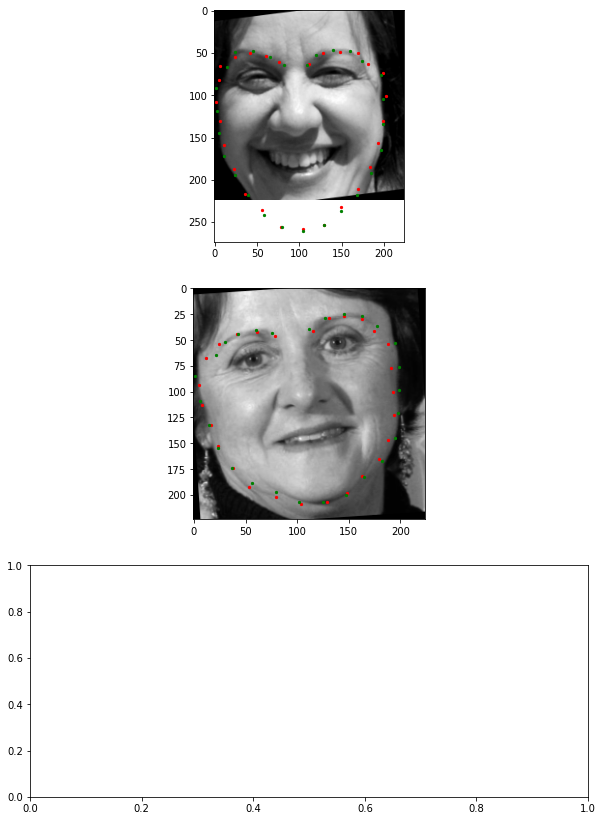

In [12]:
start_time = time.time()

with torch.no_grad():

    best_network = resnet.Network()
    best_network.to(device)
    best_network.load_state_dict(torch.load('/home/ubuntu/workspace/FLD-scratch/result/face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.to(device)
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,27,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

In [ ]:
import numpy as np

import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
import cv2
import imutils
import random
from math import *
from PIL import Image

class Transforms():
    def __init__(self):
        pass

    # def rotate(self, image, landmarks, angle):
    #     angle = random.uniform(-angle, +angle)

    #     transformation_matrix = torch.tensor([
    #         [+cos(radians(angle)), -sin(radians(angle))], 
    #         [+sin(radians(angle)), +cos(radians(angle))]
    #     ])

    #     image = imutils.rotate(np.array(image), angle)

    #     landmarks = landmarks - 0.5
    #     new_landmarks = np.matmul(landmarks, transformation_matrix)
    #     new_landmarks = new_landmarks + 0.5
    #     return Image.fromarray(image), new_landmarks
    # def add_noise(self, images):
    #     images = np.array(images)
    #     noise = 0.008 * np.random.randn(224,224,1)
    #     noise = noise.astype(np.float32)
    #     # 생성한 noise를 원본에 add
    #     noisy_image = cv2.add(images, noise)
    #     return noisy_image
    
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    # def crop_face(self, image, landmarks):

    #     img_shape = np.array(image).shape
    #     # landmarks = torch.tensor(landmarks) - torch.tensor([img_shape[1], img_shape[0]])
    #     landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
    #     return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks   


    def __call__(self, image, landmarks):
        image = Image.fromarray(image)
        landmarks = torch.tensor(landmarks)
        
        image, landmarks = self.resize(image, landmarks, (224, 224))
        # image, landmarks = self.crop_face(image, landmarks)
        image, landmarks = self.color_jitter(image, landmarks)
        # image, landmarks = self.rotate(image, landmarks, angle=10)
        # image = self.add_noise(image)
        # image = Image.fromarray(image)
        # image = A.add_no
        landmarks = landmarks * torch.tensor((1/874, 1/576))
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
from src.dataset import kface_dataset as K
dataset = K.kfacedataset(image_list=C.IMAGE_LIST, label_list=C.LABEL_LIST, transform=Transforms())

In [ ]:
# Matching Test
image, landmarks = dataset[0]
img_shape = np.array(image).shape
landmark = landmarks * torch.tensor((224,224))
plt.figure(figsize=(5, 5))
plt.imshow(image.permute(1,2,0), cmap='gray');
plt.scatter(landmark.T[0], landmark.T[1], s=8);

In [ ]:
train_dataset, valid_dataset = D.random_split(dataset, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])

train_loader = D.DataLoader(train_dataset, batch_size=C.BATCH_SIZE["TRAIN"], shuffle=True, num_workers=4)
valid_loader = D.DataLoader(valid_dataset, batch_size=C.BATCH_SIZE["VALID"], shuffle=False, num_workers=4)

train_images, train_landmarks = next(iter(train_loader))
valid_images, valid_landmarks = next(iter(valid_loader))

print(f"| Size of image in train_loader : {train_images.shape}")
print(f"| Size of label in train_loader : {train_landmarks.shape}")
print(f"| Size of image in train_loader : {valid_images.shape}")
print(f"| Size of label in train_loader : {valid_landmarks.shape}")

In [ ]:
# from torchvision import models
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# model=models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 54)

In [ ]:
model = resnet.Network()
model = model.cpu()
model.load_state_dict(torch.load("/home/ubuntu/workspace/FLD-scratch/result/face_landmarks.pth",map_location='cpu'))
model = model.to(device)

In [ ]:
# Test
x = torch.randn([1, 1, 224, 224]).to(device)
out = model(x).to(device)
print(f"input : {x.shape} | output : {out.size()}")

In [ ]:
criterion = nn.MSELoss()
optimizer = MADGRAD(params=model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=C.EPOCHS, T_mult=1)

In [ ]:
loss_min = np.inf

# torch.cuda.empty_cache()

start_time = time.time()
for epoch in range(1,201):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    model.train()
    for step in range(1,len(train_loader)+1):
        model = model.to(device)    
        
        images, landmarks = next(iter(train_loader))
        
        images = images.to(device)
        landmarks = landmarks.view([landmarks.size(0),-1]).to(device)
        
        predictions = model(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    model.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
      
            images = images.to(device)
            landmarks = landmarks.view([landmarks.size(0),-1]).to(device)
        
            predictions = model(images).to(device)
                    
            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('\n--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks_2.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, C.EPOCHS))
        print('Model Saved\n')

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = resnet.Network()
    best_network.to(device)
    best_network.load_state_dict(torch.load('/home/ubuntu/workspace/FLD-scratch/result/face_landmarks_2.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.to(device)
    landmarks = landmarks * torch.tensor((224,224))    

    predictions = best_network(images).cpu()
    predictions = predictions.view([-1,27,2])
    predictions = predictions * torch.tensor((224,224))    
    
    plt.figure(figsize=(10,20))
    
    for img_num in range(2):
        plt.subplot(2,1,img_num+1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num].T[0], predictions[img_num].T[1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num].T[0], landmarks[img_num].T[1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 